In [1]:
# setup
import os
from dataclasses import dataclass
from typing import Any, Dict, List, Literal, Optional, TypedDict

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.state import CompiledStateGraph
from pydantic import BaseModel, Field
from tavily import TavilyClient

# load environment variables - api keys
from dotenv import load_dotenv

load_dotenv()
# config

REPUTABLE_DOMAINS = [
    "nhs.uk", "who.int", "cdc.gov", "medlineplus.gov", "nih.gov",
    "mayoclinic.org", "cancer.gov", "nice.org.uk", "ema.europa.eu"
]
MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")  # pick the model
TEMPERATURE = float(os.getenv("OPENAI_TEMPERATURE", "0.2"))
MAX_RESULTS = 5

# Instantiate the chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
   # api_key = "YOUR_API_KEY_HERE",   # in my venv
)

In [2]:
# state schema

class HealthState(TypedDict, total=False):
    topic: Optional[str]
    search_results: Optional[List[Dict[str, Any]]]
    corpus: Optional[str]          # concatenated full-text extracts
    summary: Optional[str]
    quiz_question: Optional[str]
    correct_answer: Optional[str]
    user_answer: Optional[str]
    grade: Optional[str]           # e.g., "Correct" / "Incorrect"
    feedback: Optional[str]        # must include citations
        # For CLI driving/human-in-the-loop:
    human_input: Optional[str]
    continue_flag: Optional[bool]  # True to start over; False to exit


In [3]:
# helper prompts

SAFETY_PREAMBLE = """\
You are a patient education assistant. Follow these rules:
- Provide general, patient-friendly information only. Do NOT give medical advice, diagnosis, or treatment recommendations.
- Urge patients to consult a qualified clinician for personal medical concerns or emergencies.
- Use plain language. Explain acronyms on first use.
- Cite sources clearly with bracketed references like [NHS], [CDC], [WHO], [NIH], [MayoClinic], etc.
"""

SUMMARIZE_PROMPT = """\
{preamble}
Summarize the key information on the topic: "{topic}" using ONLY the following source extracts.
Write for a UK patient audience (plain English, neutral tone). Include a short bullet list of key takeaways, and clearly list sources at the end in square brackets.
Avoid advice: if a section implies treatment or diagnosis, state that the patient should consult a clinician.

SOURCE EXTRACTS:
{corpus}
"""

QUIZ_PROMPT = """\
{preamble}
Create ONE multiple-choice comprehension question (A to D) based ONLY on the summary below.
- Make it directly test a key fact.
- Provide the correct answer (A to D) and a one-sentence rationale.

SUMMARY:
{summary}

Return JSON with fields: question, choices (list of 4), correct_letter, rationale.
"""

GRADE_PROMPT = """\
{preamble}
Grade the patient's answer to the quiz based ONLY on the summary below.
- Respond "Correct" or "Incorrect".
- Provide 2 to 4 sentences of feedback that cite the summary with inline bracketed source tags (e.g., [NHS], [CDC]) that appear IN THE SUMMARY TEXT.
- If the summary does not support grading, say so.

SUMMARY:
{summary}

QUESTION:
{question}

CORRECT ANSWER: {correct_letter}
PATIENT ANSWER: {user_answer}
"""

## Nodes

In [4]:
# This node waits for human_input to be typed in (CLI driver or UI).

def ask_topic(state: HealthState) -> HealthState:
    topic = state.get("human_input")
    out: HealthState = {"next_action": "search"}
    if topic:
        out["topic"] = topic.strip()
    return out

def search_tavily(state: HealthState) -> HealthState:
    topic = state["topic"]
    # Prefer reputable domains using Tavily's domain filter and textual query
    query = f"{topic} site:({' OR '.join(REPUTABLE_DOMAINS)})"
    # Tavily 'search' for links
    results = tavily_client.search(query=query, include_raw_content=False, max_results=MAX_RESULTS)
    # Retrieve full page text for each result (best-effort: skip failures)
    corpus_parts = []
    curated_results = []
    for r in results.get("results", [])[:MAX_RESULTS]:
        url = r.get("url")
        if not url:
            continue
        # filter by domain whitelist
        if not any(d in url for d in REPUTABLE_DOMAINS):
            continue
        try:
            page = tavily_client.get_page_content(url)
            content = page.get("content", "") or ""
            if content.strip():
                # keep a concise chunk to avoid context overflow
                snippet = content[:6000]
                corpus_parts.append(f"URL: {url}\n\n{snippet}")
                curated_results.append({"url": url, "title": r.get("title", "")})
        except Exception:
            continue

    return {
        "search_results": curated_results,
        "corpus": "\n\n---\n\n".join(corpus_parts),
        "next_action": "summarize",
    }
def summarize(state: HealthState) -> HealthState:
    corpus = state.get("corpus") or ""
    topic = state["topic"]
    if not corpus.strip():
        # Fall back on a safer message if nothing fetched
        summary = (
            f"{SAFETY_PREAMBLE}\n\n"
            "I couldn’t retrieve reliable sources just now. Please try a different phrasing "
            "or consult trusted sites like NHS, WHO, or CDC."
        )
    else:
        prompt = SUMMARIZE_PROMPT.format(
            preamble=SAFETY_PREAMBLE, topic=topic, corpus=corpus
        )
        summary = llm.invoke(prompt).content

    return {"summary": summary, "next_action": "show_summary_and_wait"}

def show_summary_and_wait(state: HealthState) -> HealthState:
    # This is a pause point for the UI to display summary and wait for user "ready".
    # Driver should set human_input to e.g. "ready" to continue.
    return {"next_action": "generate_quiz"}
def generate_quiz(state: HealthState) -> HealthState:
    summary = state["summary"]
    prompt = QUIZ_PROMPT.format(preamble=SAFETY_PREAMBLE, summary=summary)
    resp = llm.invoke(prompt).content
    # simple JSON extraction (be defensive)
    import json
    try:
        data = json.loads(resp)
        question = data["question"]
        choices = data["choices"]
        correct_letter = data["correct_letter"].strip().upper()
        rationale = data.get("rationale", "")
        # bake choices into the question text for easy display
        q_text = question + "\n" + "\n".join([f"{chr(65+i)}. {c}" for i, c in enumerate(choices)])
        return {"quiz_question": q_text, "correct_answer": correct_letter, "next_action": "present_quiz_and_wait"}
    except Exception:
        # Fallback: basic dummy if parsing failed
        fallback_q = "Which organization is known for UK public health guidance?\nA. NASA\nB. NHS\nC. IMF\nD. FIFA"
        return {"quiz_question": fallback_q, "correct_answer": "B", "next_action": "present_quiz_and_wait"}

def present_quiz_and_wait(state: HealthState) -> HealthState:
    # Pause for user's answer (driver sets human_input to 'A'/'B'/'C'/'D')
    return {"next_action": "grade_quiz"}

def grade_quiz(state: HealthState) -> HealthState:
    summary = state["summary"]
    question = state["quiz_question"]
    correct_letter = (state["correct_answer"] or "").strip().upper()
    user_answer = (state.get("human_input") or "").strip().upper()

    prompt = GRADE_PROMPT.format(
        preamble=SAFETY_PREAMBLE,
        summary=summary,
        question=question,
        correct_letter=correct_letter,
        user_answer=user_answer or "N/A",
    )
    resp = llm.invoke(prompt).content

    # Heuristic: grade line then feedback body
    grade = "Correct" if user_answer == correct_letter else "Incorrect"
    feedback = resp
    return {"user_answer": user_answer, "grade": grade, "feedback": feedback, "next_action": "present_grade"}


In [5]:
def present_grade(state: HealthState) -> HealthState:
    # UI shows grade + feedback; then flow moves to decide_continue
    return {"next_action": "decide_continue"}


In [6]:

def decide_continue(state: HealthState) -> HealthState:
    # Driver should set continue_flag True/False based on user input
    return {"next_action": "reset_or_exit"}

In [7]:
def reset_or_exit(state: HealthState) -> HealthState:
    if state.get("continue_flag"):
        # Reset privacy-sensitive fields before looping
        return {
            "topic": None,
            "search_results": None,
            "corpus": None,
            "summary": None,
            "quiz_question": None,
            "correct_answer": None,
            "user_answer": None,
            "grade": None,
            "feedback": None,
            "human_input": None,
            "next_action": "ask_topic",
        }
    else:
        return END

## The Graph

In [8]:
workflow = StateGraph(HealthState)

# Nodes
workflow.add_node("ask_topic", ask_topic)
workflow.add_node("search", search_tavily)
workflow.add_node("summarize", summarize)
workflow.add_node("show_summary_and_wait", show_summary_and_wait)
workflow.add_node("generate_quiz", generate_quiz)
workflow.add_node("present_quiz_and_wait", present_quiz_and_wait)
workflow.add_node("grade_quiz", grade_quiz)
workflow.add_node("present_grade", present_grade)
workflow.add_node("decide_continue", decide_continue)
workflow.add_node("reset_or_exit", reset_or_exit)

# Edges
workflow.add_edge(START, "ask_topic")
workflow.add_edge("ask_topic", "search")
workflow.add_edge("search", "summarize")
workflow.add_edge("summarize", "show_summary_and_wait")
workflow.add_edge("show_summary_and_wait", "generate_quiz")
workflow.add_edge("generate_quiz", "present_quiz_and_wait")
workflow.add_edge("present_quiz_and_wait", "grade_quiz")
workflow.add_edge("grade_quiz", "present_grade")
workflow.add_edge("present_grade", "decide_continue")
workflow.add_edge("decide_continue", "reset_or_exit")


In [9]:
graph = workflow.compile()

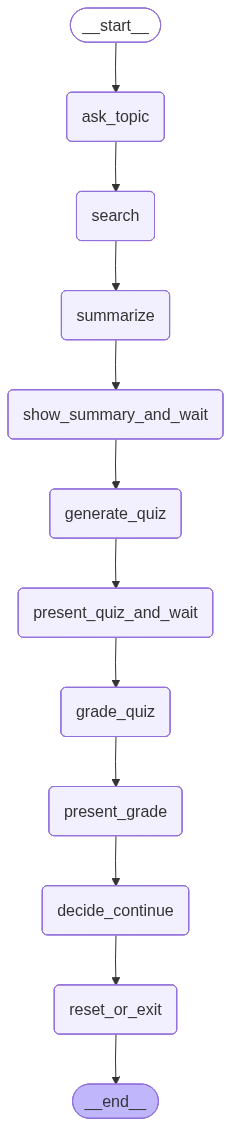

In [10]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)